# K-Means

In [135]:
import pandas as pd
import math
import numpy as np
from matplotlib import pyplot as plt
from numpy import logical_and as land, logical_or as lor
import seaborn as sn
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode
from scipy.cluster.hierarchy import linkage, dendrogram

In [2]:
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = '/content/drive/MyDrive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df_indicators = pd.read_csv(DATA_PATH+'indicators.csv', sep='#')
#df_tweets_ind = pd.read_csv(DATA_PATH+'tweets_with_indicators.csv', sep='#')
df_users = pd.read_csv(DATA_PATH+'users_clean.csv', sep='#')

In [123]:
def scatterplot(df, attr1, attr2, c_labels, centroids=None):
  #cent = scaler.inverse_transform(kmeans.cluster_centers_)
  plt.scatter(df_merge[attr1], df_merge[attr2], c=kmeans.labels_)

  if centroids is not None:
    plt.scatter(centroids[:, 0], centroids[:, 1], s=100, marker='.', c='r')
    
  plt.tick_params(axis='both', which='major')
  plt.show()


In [126]:
def get_metrics(data_scaled, labels):
  print(metrics.silhouette_score(data_scaled, labels)) # [-1, 1] Good when near 1
  print(metrics.davies_bouldin_score(data_scaled, labels)) # Good when near 0

In [4]:
df_indicators.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 222285 entries, 0 to 222284
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   user_id              222285 non-null  object 
 1   n_tweets             222285 non-null  int64  
 2   2012_tweets          222285 non-null  int64  
 3   2013_tweets          222285 non-null  int64  
 4   2014_tweets          222285 non-null  int64  
 5   2015_tweets          222285 non-null  int64  
 6   2016_tweets          222285 non-null  int64  
 7   2017_tweets          222285 non-null  int64  
 8   2018_tweets          222285 non-null  int64  
 9   2019_tweets          222285 non-null  int64  
 10  2020_tweets          222285 non-null  int64  
 11  mean_length          222285 non-null  float64
 12  mean_special_chars   222285 non-null  float64
 13  retweets_count_mean  222285 non-null  float64
 14  retweets_count_std   17094 non-null   float64
 15  reply_count_mean 

In [90]:
df_users.id = df_users.id.astype(str)
df_merge = df_users.merge(df_indicators, left_on='id', right_on='user_id', how='left')

In [91]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   11508 non-null  object 
 1   name                 11507 non-null  object 
 2   lang                 11508 non-null  object 
 3   bot                  11508 non-null  int64  
 4   created_at           11508 non-null  object 
 5   statuses_count       11508 non-null  float64
 6   created_at_conv      11508 non-null  int64  
 7   user_id              11508 non-null  object 
 8   n_tweets             11508 non-null  int64  
 9   2012_tweets          11508 non-null  int64  
 10  2013_tweets          11508 non-null  int64  
 11  2014_tweets          11508 non-null  int64  
 12  2015_tweets          11508 non-null  int64  
 13  2016_tweets          11508 non-null  int64  
 14  2017_tweets          11508 non-null  int64  
 15  2018_tweets          11508 non-null 

Drop categorical columns

In [92]:
df_merge.drop(columns=['id', 'user_id', 'name', 'lang', 'created_at', 'bot'], inplace=True)
df_merge.drop(columns=[str(y)+'_tweets' for y in range(2012,2021)], inplace=True)

In [93]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   statuses_count       11508 non-null  float64
 1   created_at_conv      11508 non-null  int64  
 2   n_tweets             11508 non-null  int64  
 3   mean_length          11508 non-null  float64
 4   mean_special_chars   11508 non-null  float64
 5   retweets_count_mean  11508 non-null  float64
 6   retweets_count_std   11414 non-null  float64
 7   reply_count_mean     11508 non-null  float64
 8   reply_count_std      11414 non-null  float64
 9   favorite_count_mean  11508 non-null  float64
 10  favorite_count_std   11414 non-null  float64
 11  num_hashtags_mean    11508 non-null  float64
 12  num_hashtags_std     11414 non-null  float64
 13  num_urls_mean        11508 non-null  float64
 14  num_urls_std         11414 non-null  float64
 15  num_mentions_mean    11508 non-null 

In [94]:
# Replace NaN values in variance with 0 
# (NaN values are given when the user only has one tweet so it is safe to assume variance can be 0)

df_merge = df_merge.fillna(value=0)
df_merge.drop(columns=['created_at_conv', 'created_at_mean', 'created_at_std'], inplace=True)

In [95]:
df_merge['statuses_count']

0          76.0
1          54.0
2           3.0
3          50.0
4        7085.0
          ...  
11503    1126.0
11504    3024.0
11505       6.0
11506      42.0
11507    5279.0
Name: statuses_count, Length: 11508, dtype: float64

# Normalization of values

In [96]:
def to_log(df, attr):
  df[attr] = np.log(df[attr].values)
  df[attr] = df[attr].replace(-np.inf, 0)
  df[attr] = df[attr].fillna(value = 0)
  return df[attr]

It is possible to see that our data has very different ranges of values for different attributes going from ranges from 0 to hundreds and from 0 to hundred thousands. This means that it would be best to normalize the values either in a range [0, 1] or in logscale.

In [97]:
for attr in df_merge.columns:
  print(attr)
  print(df_merge[attr].max())
  print(df_merge[attr].min())

statuses_count
399555.0
0.0
n_tweets
3929
1
mean_length
245.0
3.0
mean_special_chars
145.0
0.0
retweets_count_mean
68360.26666666666
0.0
retweets_count_std
154043.43862339295
0.0
reply_count_mean
60.7
0.0
reply_count_std
92.91579222309008
0.0
favorite_count_mean
10417.153846153846
0.0
favorite_count_std
37522.39658848552
0.0
num_hashtags_mean
5.946500549651887
0.0
num_hashtags_std
10.063429067092097
0.0
num_urls_mean
2.0
0.0
num_urls_std
2.489422801952504
0.0
num_mentions_mean
5.089430894308944
0.0
num_mentions_std
6.858739072630573
0.0
max_daily_tweets
2268
1


In [98]:
# Log scale
df_merge_log = pd.DataFrame()

for attr in df_merge.columns:
  print(attr)
  df_merge_log[attr] = to_log(df_merge, attr)
  print(df_merge_log[attr].max())
  print(df_merge_log[attr].min())

df_merge_log.info()

statuses_count
12.898106706802647
0.0
n_tweets
8.27614021955846
0.0
mean_length
5.501258210544727
1.0986122886681098
mean_special_chars
4.976733742420574
-2.708050201102211
retweets_count_mean
11.132547038138634
-4.584967478670578
retweets_count_std
11.94498991060486
-2.2924837393352866
reply_count_mean
4.1059436980654525
-4.20469261939097
reply_count_std
4.531693623009989
-2.1023463096954833
favorite_count_mean
9.25120913463356
-4.788602237066075
favorite_count_std
10.532693276039877
-2.3982030335413005
num_hashtags_mean
1.7828029036179993
-8.226573474977473
num_hashtags_std
2.308907968131466
-4.113286737488558
num_urls_mean
0.6931471805599453
-8.225235324101773
num_urls_std
0.9120508771605722
-4.112617662050837
num_mentions_mean
1.6271660157276813
-8.232440158470565
num_mentions_std
1.9255236161884772
-4.1162200792351715
max_daily_tweets
7.7266536648476425
0.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11508 entries, 0 to 11507
Data columns (total 17 columns):
 #   Column     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


In [99]:
# 3 alternative:

# 1. Normalizzare i valori (escono grafici di merda)
#scaler = StandardScaler()
#scaler.fit(df_merge.values)
# df_merge_scaled = scaler.transform(df_merge.values)

# Normalizzare i valori in log
scaler = StandardScaler()
scaler.fit(df_merge.values)
df_merge_scaled = scaler.transform(df_merge_log.values)

# Dare i valori in log (Decente)
#df_merge_scaled = df_merge_log.values

In [100]:
df_merge_scaled

array([[-0.42588762, -0.30782327, -0.23555985, ..., -0.04781064,
        -0.17588812, -0.05537517],
       [-0.55475637, -0.34784789,  0.1622966 , ...,  0.08965256,
        -0.09413006, -0.01959238],
       [-1.64467405, -2.08422396, -5.02183846, ...,  0.80743132,
         0.93649435, -1.24119833],
       ...,
       [-1.3832982 , -1.79991116,  0.35923059, ..., -0.01718924,
        -0.05495403, -1.24119833],
       [-0.64952343, -0.42408623, -0.21185654, ...,  0.13841166,
        -0.06945384, -0.27074639],
       [ 1.17324156,  1.38482827, -0.97530402, ...,  0.59003704,
         0.52876067,  1.56738388]])

# KMeans

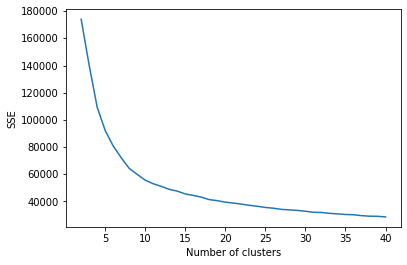

In [23]:
max_k = 40
sse_list = list()

for k in range(2, max_k+1):
  kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
  kmeans.fit(df_merge_scaled)
  sse_list.append(kmeans.inertia_)

plt.plot(range(2, len(sse_list)+2), sse_list)
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

In [101]:
k = 8
kmeans = KMeans(n_clusters = k, n_init=10, max_iter=100)
kmeans.fit(df_merge_scaled)

KMeans(max_iter=100)

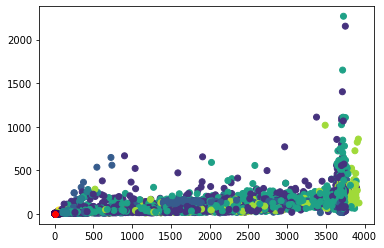

In [124]:
#cent = scaler.inverse_transform(kmeans.cluster_centers_)
cent = kmeans.cluster_centers_

scatterplot(df_merge, 'n_tweets', 'max_daily_tweets', kmeans.labels_, cent)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9dae1e9d90>,
      dtype=object)

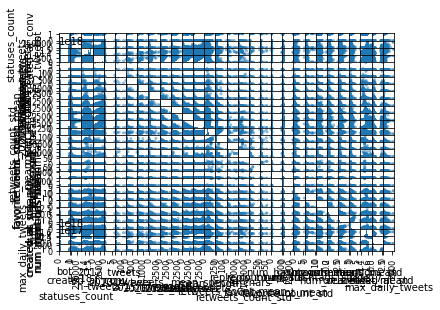

In [119]:
pd.plotting.scatter_matrix(df_merge)

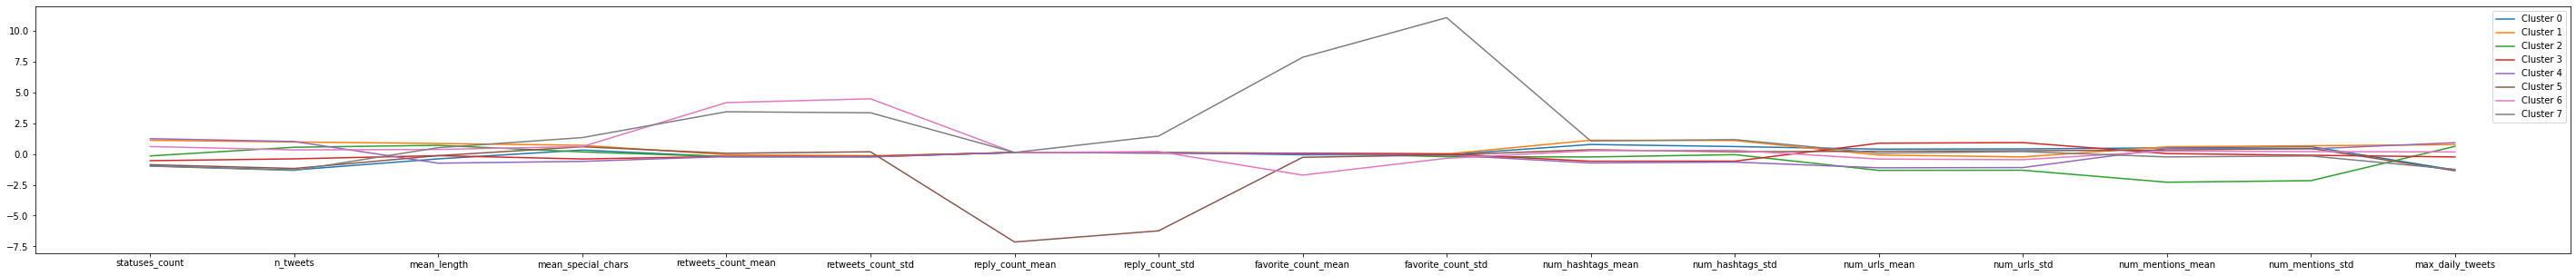

In [103]:
plt.figure(figsize=(50,5))
for i in range(0, len(cent)):
  plt.plot(cent[i], label="Cluster %s" % i)
plt.tick_params(axis='both', which='major')
plt.xticks(range(0, len(df_merge.columns)), df_merge.columns)
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


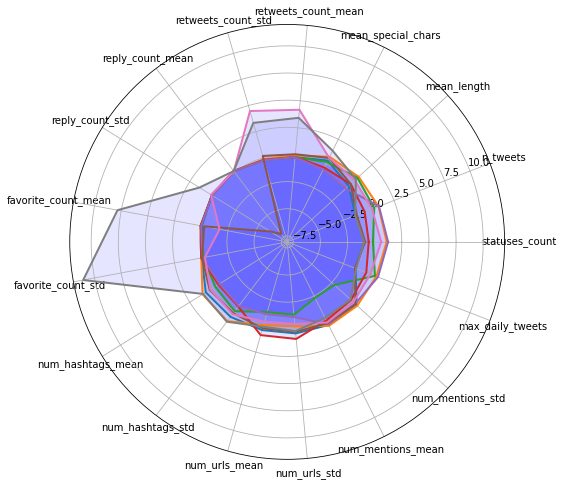

In [104]:
N = len(df_merge.columns)

plt.figure(figsize=(8,8))
for i in range(0, len(cent)):
  angles = [n / float(N)*2*math.pi for n in range(N)]
  values = cent[i].tolist()
  values += values[:1]
  angles += angles[:1]

  ax = plt.subplot(polar=True)
  plt.xticks(angles[:-1], df_merge.columns)
  ax.plot(angles, values, linewidth=2)
  ax.fill(angles, values, 'b', alpha=0.1)

In [127]:
get_metrics(df_merge_scaled, kmeans.labels_)

0.3560035804008032
1.0731207465471582


In [106]:
# Re-initialize Categorical features
df_users.id = df_users.id.astype(str)
df_merge = df_users.merge(df_indicators, left_on='id', right_on='user_id', how='left')


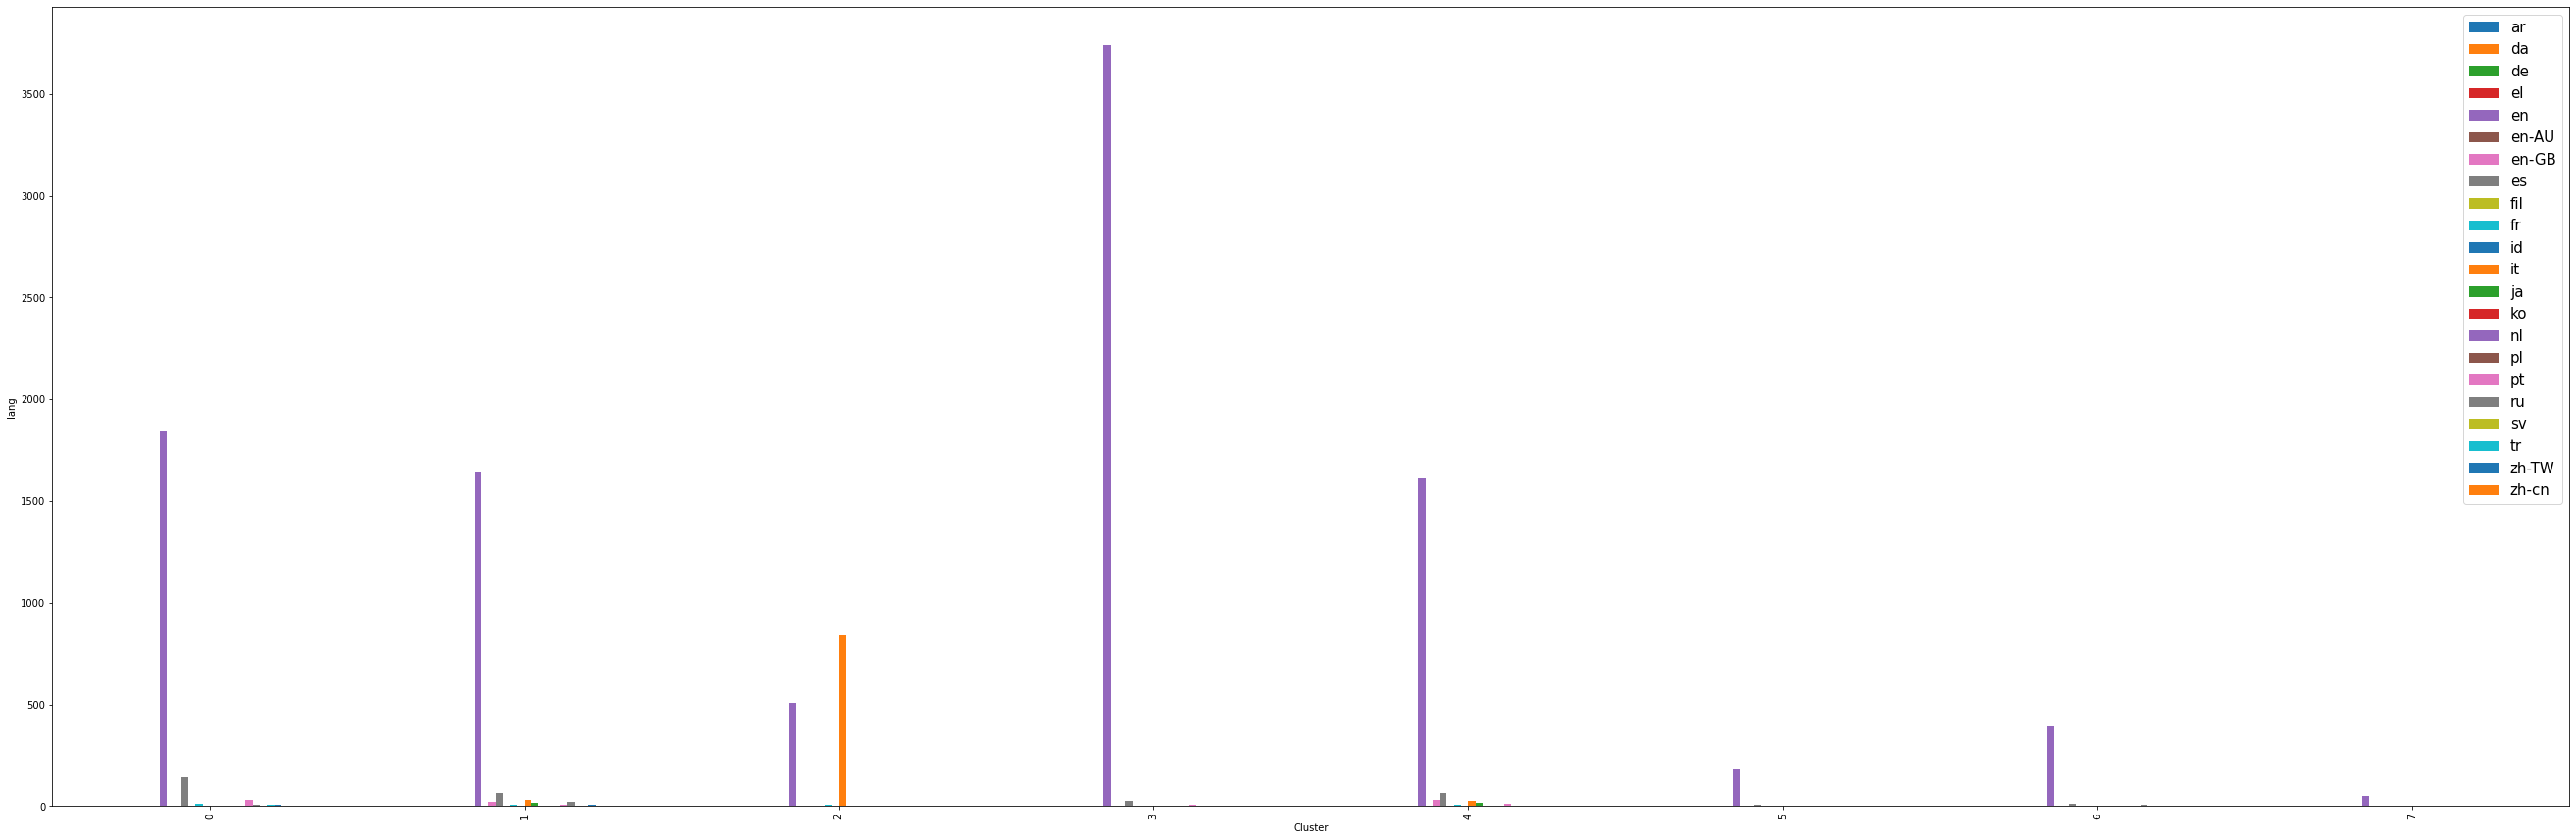

In [107]:
lang_ct = pd.crosstab(kmeans.labels_, df_merge['lang'])

fig, ax = plt.subplots(figsize=(46,15))  
#plt.figure(figsize=(10,25))
lang_ct.plot(kind='bar', stacked = False, ax=ax)
plt.xlabel('Cluster')
plt.ylabel('lang')
plt.legend(prop={'size': 15})
plt.show()

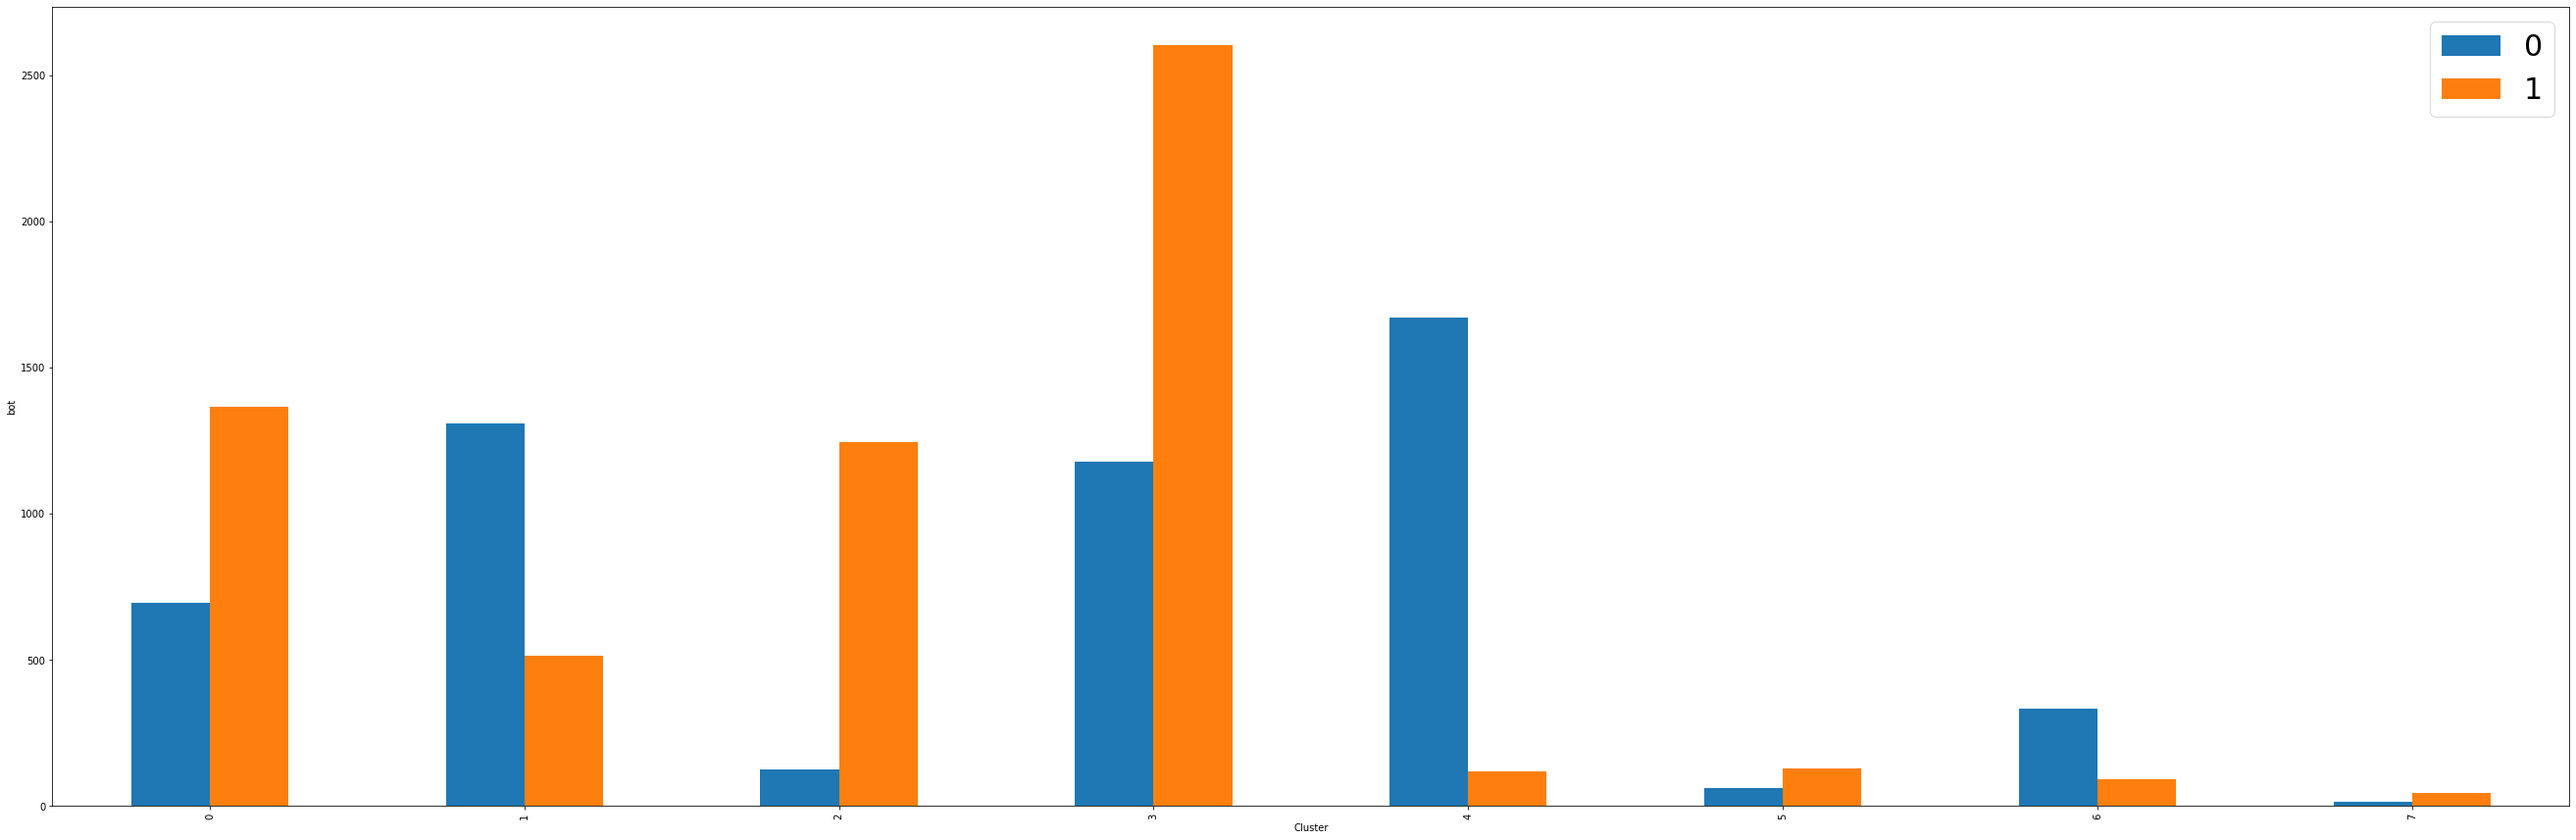

In [108]:
bot_ct = pd.crosstab(kmeans.labels_, df_merge['bot'])

fig, ax = plt.subplots(figsize=(46,15))         # Sample figsize in inches
#plt.figure(figsize=(10,25))
bot_ct.plot(kind='bar', stacked = False, ax=ax)
plt.xlabel('Cluster')
plt.ylabel('bot')
plt.legend(prop={'size': 30})
plt.show()

# DB Scan

In [114]:
dbscan = DBSCAN(eps=0.35, min_samples=10)
dbscan.fit(df_merge_scaled)

DBSCAN(eps=0.35, min_samples=10)

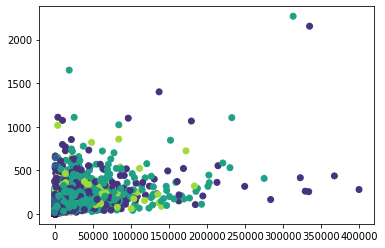

In [125]:
scatterplot(df_merge, 'statuses_count', 'max_daily_tweets', dbscan.labels_)

In [128]:
get_metrics(df_merge_scaled, dbscan.labels_)

-0.057686814553778075
1.14408408401098


In [131]:
dist = pdist(df_merge_scaled, 'euclidean')
dist_matrix = squareform(dist)

In [132]:
distances = list()

for d in dist_matrix:
  index_kth_distance = np.argsort(d)[k]
  distances.append(d[index_kth_distance])

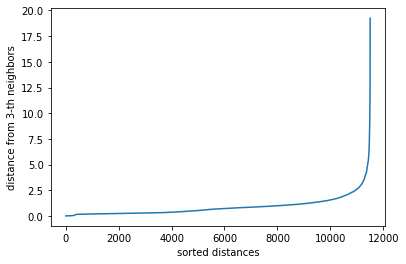

In [133]:
plt.plot(range(0, len(distances)), sorted(distances))
plt.ylabel('distance from %s-th neighbors' % 3)
plt.xlabel('sorted distances')
plt.show()

# Hierarchical clustering

In [140]:
metric = 'euclidean'
distances = pdist(df_merge_scaled, metric=metric)

In [141]:
dlinkage = linkage(distances, metric=metric, method='complete')

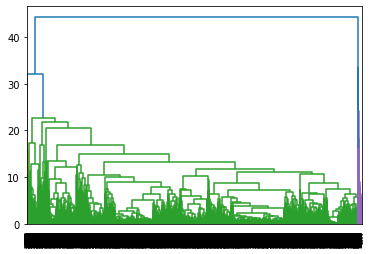

In [142]:
res = dendrogram(dlinkage, truncate_mode='lastp')